## Setup

#### Importing necessary libraries

In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score
from sklearn import tree
import combined_data

%matplotlib inline

dev_dataset_rows = 100000

## Data Prepartaion

### Loading movie titles

In [122]:
columns = [0,1,2]
movies = pd.read_csv(
    "netflix-data/movie_titles.csv",
    encoding="ISO-8859-1",
    usecols=columns
)
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17770 entries, 0 to 17769
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      17770 non-null  int64  
 1   Year    17763 non-null  float64
 2   Title   17770 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 416.6+ KB


Only 7 titles have missing data so they are dropped and years converted to int values

In [123]:
movies.dropna(inplace=True)
movies.Year = movies.Year.astype(int)
movies

,ID,Year,Title
0,1,2003,Dinosaur Planet
1,2,2004,Isle of Man TT 2004 Review
2,3,1997,Character
3,4,1994,Paula Abdul's Get Up & Dance
4,5,2004,The Rise and Fall of ECW
...,...,...,...
17765,17766,2002,Where the Wild Things Are and Other Maurice Se...
17766,17767,2004,Fidel Castro: American Experience
17767,17768,2000,Epoch
17768,17769,2003,The Company


### Examining the ratings dataset

Converting `combined_data_n.txt` files into feather format if necessary and loading them for analysis. (Functions defined in `combined_data.py`) 

In [124]:
combined_data.initialize_all_data()
ratings = pd.read_feather(combined_data.combined_ratings_path())
ratings = ratings.head(dev_dataset_rows)
ratings.head()

,movie,user,rating
0,1,1488844,3
1,1,822109,5
2,1,885013,4
3,1,30878,4
4,1,823519,3


In [125]:
ratings.dtypes

movie     int64
user      int64
rating    int64
dtype: object

In [126]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   movie   100000 non-null  int64
 1   user    100000 non-null  int64
 2   rating  100000 non-null  int64
dtypes: int64(3)
memory usage: 2.3 MB


The dataset has no missing values

In [127]:
ratings.isna().sum()

movie     0
user      0
rating    0
dtype: int64

Dataframe shape (Over 24m ratings)

In [128]:
ratings.shape

(100000, 3)

No duplicate ratings in the dataset

In [129]:
ratings.duplicated().any()

False

## Eploratory Data Analysis

### Ratings bar plot

In [130]:
ratings_count = ratings.rating.value_counts()
ratings_count

rating
4    33021
3    28619
5    21491
2    10949
1     5920
Name: count, dtype: int64

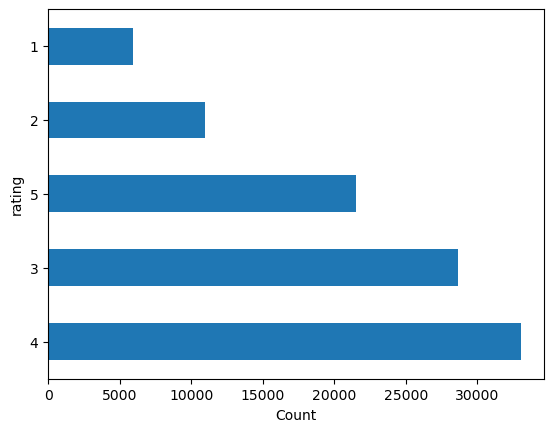

In [131]:
ratings_count.plot(kind="barh", xlabel="Count");

#### Observation

The vast majority of films are rated favorably or neutral<hr>

### Ratings box plot

In [132]:
ratings.rating.median()

4.0

In [133]:
q1 = np.percentile(ratings.rating, 25)
q3 = np.percentile(ratings.rating, 75)
iqr = q3 - q1
print(f"Q1: {q1}\nQ3:{q3}\nInterquartile Range:{iqr}")

Q1: 3.0
Q3:4.0
Interquartile Range:1.0


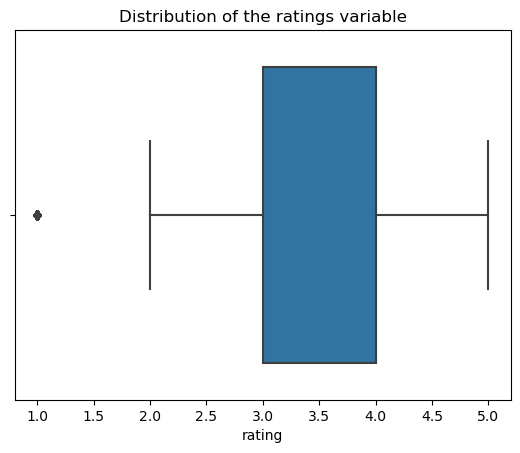

In [134]:
sns.boxplot(x='rating', data=ratings)
plt.title("Distribution of the ratings variable");

#### Observations
- The ratings have a median of 4 and an IQR of 1
- There appears to be outliers at the lower end of the ratings which might indicate class imbalance
<hr>

### Reducing rating categories (Negative: 0, Neutral: 1, Positive: 2)

In [135]:
ratings["category"] = ratings.rating.apply(
    lambda x:
        0 if x == 1 or x == 2 
        else(1 if x ==3 else 2)
)
ratings.head()

,movie,user,rating,category
0,1,1488844,3,1
1,1,822109,5,2
2,1,885013,4,2
3,1,30878,4,2
4,1,823519,3,1


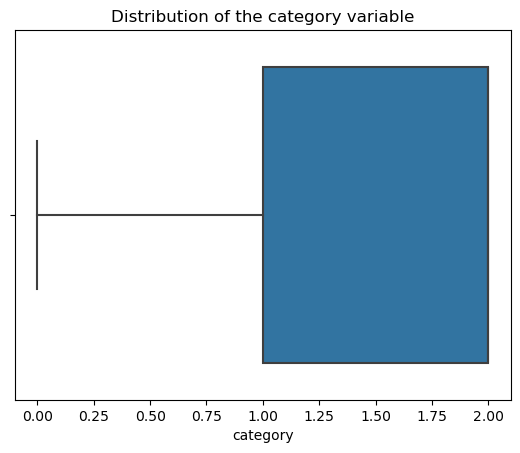

In [136]:
sns.boxplot(x='category', data=ratings)
plt.title("Distribution of the category variable");

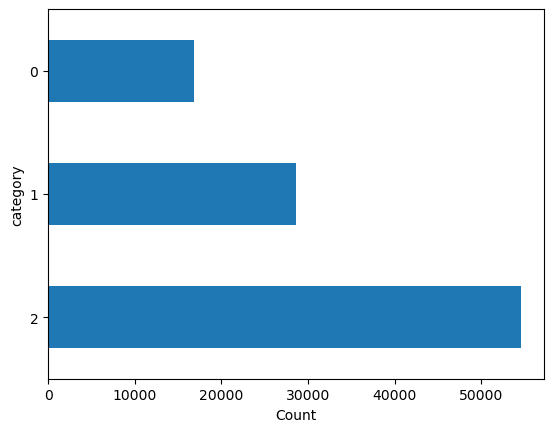

In [137]:
ratings_count = ratings.category.value_counts()
ratings_count.plot(kind="barh", xlabel="Count");

#### Observations
Reducing the categories reduces the strength of the outliers
<hr>

With our rating categories set, we can drop the original rating column

In [138]:
ratings.drop("rating", axis=1, inplace=True)
ratings

,movie,user,category
0,1,1488844,1
1,1,822109,2
2,1,885013,2
3,1,30878,2
4,1,823519,1
...,...,...,...
99995,30,2146325,2
99996,30,2103907,1
99997,30,2581477,2
99998,30,2182488,2


### Heatmap

In [139]:
ratings_corr =  ratings.corr()
ratings_corr

,movie,user,category
movie,1.000000,-0.003074,0.169375
user,-0.003074,1.000000,0.001786
category,0.169375,0.001786,1.000000


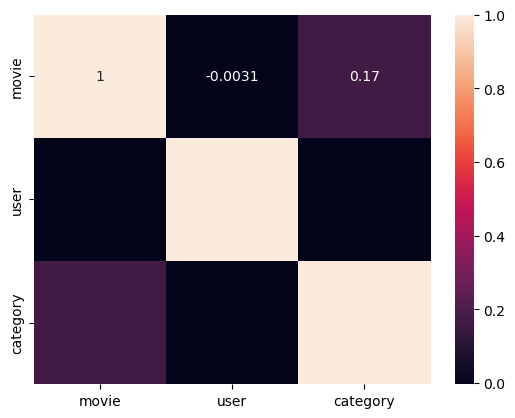

In [140]:
sns.heatmap(ratings_corr, annot=True);

#### Observations
There appears to be no strong correlation between any of the variables. This indicates a non-linear more omplex relationship

## Modeling

In [141]:
y = ratings.category
X = ratings.drop("category", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [142]:
clf = DecisionTreeClassifier(criterion='entropy')
clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy')

In [143]:
"""fig, axes = plt.subplots(nrows = 1,ncols = 1, figsize = (3,3), dpi=300)
tree.plot_tree(clf,
               feature_names = ratings.columns, 
               class_names=np.unique(y).astype('str'),
               filled = True)
plt.show()"""

"fig, axes = plt.subplots(nrows = 1,ncols = 1, figsize = (3,3), dpi=300)\ntree.plot_tree(clf,\n               feature_names = ratings.columns, \n               class_names=np.unique(y).astype('str'),\n               filled = True)\nplt.show()"

In [144]:
y_preds = clf.predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_preds))

Accuracy:  0.44533333333333336


In [147]:
y_preds[:10]

array([2, 1, 2, 1, 2, 0, 2, 1, 2, 2])

In [148]:
y_test.head(10)

86997    1
34768    2
15615    0
4956     2
59696    1
18561    0
33458    2
75863    2
80408    2
14505    0
Name: category, dtype: int64

todo

add year to dataset
try forest
other models